Import packages

In [155]:
import matplotlib 
from matplotlib import cm
from matplotlib.animation import *
from mpl_toolkits.mplot3d import *
from matplotlib import pyplot as plt
import matplotlib.animation as animation
import numpy as np

from IPython import display
from qutip import *
from qutip.ipynbtools import plot_animation

from qiskit import *
from qiskit.visualization import plot_bloch_vector

import time
import math


Loading in data

In [117]:
density_matrix = np.loadtxt("rho_pump.txt", dtype=complex, converters={0: lambda s: complex(s.decode().replace('+-', '-'))})
sim_time = np.loadtxt("time.txt")

Reshaping density_matrix 

In [118]:
density_matrix = np.reshape(density_matrix,(4,4,np.size(sim_time)))

Define Vector Space 

In [15]:
vec_interval = 600
xvec = np.linspace(-2.8,2.8,vec_interval)
X,Y = np.meshgrid(xvec, xvec)


Defining time_index function 

In [16]:
def find_time_index(timestamps, time_list):
    t_length = len(time_list)
    t_range = int(round((time_list[-1]-time_list[0])*1E15,0))
    t_interval= int(round((t_length/t_range),0))
    t_half = int(round(t_length/2 ,0))
    t_index = []
    for i in timestamps:
        t_index.append(t_half + (i*t_interval))

    return t_index

Plotting 2D plots

Specifiy which times to plot

In [89]:
times = [-175,0,175,350,500]

Plotting Total Wigner Distrubution

<function matplotlib.pyplot.draw()>

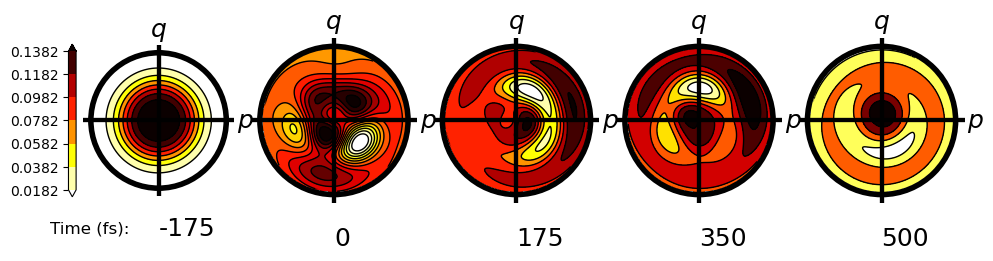

In [104]:
%matplotlib inline 

t_list = find_time_index(times,sim_time)

fig = plt.figure(figsize=(10,5))

for idx, m in enumerate(t_list):
    dm_dummy = density_matrix[:,:,m]
    dm_dummy = np.matrix(dm_dummy) #Dummy Array
    dm_dummy = Qobj(dm_dummy) #Converting to a quantum object
    W = wigner(dm_dummy, xvec, xvec, method='laguerre')
    name = str(times[idx])

    radius = 2.5
    [size_W,size_W] = np.shape(W)
    xy_interval = radius*2/size_W

    for i in range(-int(vec_interval/2),int(vec_interval/2),1):
        for j in range(-int(vec_interval/2),int(vec_interval/2),1):

            if np.sqrt((i*xy_interval)**2+(j*xy_interval)**2)>radius-0.36:
                W[i+int(vec_interval/2),j+int(vec_interval/2)] = np.NaN


    ax = fig.add_subplot(1,len(t_list), idx+1 ,aspect =1)
    plt.tight_layout()
    poslim = np.nanmax(W)
    neglim = np.nanmin(W) + 0.1*(np.nanmax(W)-np.nanmin(W))                 
    levels = np.arange(neglim,poslim,0.02) 
 
    cmap = cm.get_cmap('hot_r')
    cmap.set_under('white')
    cf = ax.contourf(X, Y, W, levels, cmap = cmap ,extend="both")
    if idx == 0:    
        cb=plt.colorbar(cf,orientation='vertical',fraction=0.046, pad=0.04, location='left')
    cf = ax.contour(X, Y, W, levels, colors='black', extend="both",linestyles='solid',negative_linestyles='solid',linewidths = 1)

    xy_center = [0,0]   # center of the plot
    circle = mpl.patches.Circle(xy = xy_center, radius = radius, edgecolor = "black", facecolor = "none",linewidth = 4)
    
    ax.add_patch(circle)
    i = radius+0.3
    xy = [[i,0], [0,0],[-i,0]]
    polygon=mpl.patches.Polygon(xy = xy, edgecolor = "black", facecolor = "none",linewidth = 3)
    ax.add_patch(polygon)
    xy = [[0,i], [0,0],[0,-i]]
    polygon=mpl.patches.Polygon(xy = xy, edgecolor = "black", facecolor = "none",linewidth = 3)
    ax.add_patch(polygon)
    
    plt.axis('off')
    
    t_print = times[idx]
   
    #ax.text(0,-5, t_print , fontsize=20,weight='bold',horizontalalignment='center') 
    ax.text(0,radius+0.6, 'q' , fontsize=18,horizontalalignment='center',style='italic')
    ax.text(radius+0.4,0, 'p' , fontsize=18,verticalalignment='center',style='italic')
    ax.text(0,-4, name , fontsize=18,verticalalignment='center')
    if idx == 0:
        ax.text(-4,-4, str('Time (fs):') , fontsize=12,verticalalignment='center',)

    plt.subplots_adjust(wspace=0.1, hspace=0.1)
plt.draw


Plotting GS and ES seperated

Note including electronic coherence. This is an example of setting various parts of the DM to 0. You can use this to see different parts of the Wigner. A superposition of all like above can be confusing 

<function matplotlib.pyplot.draw()>

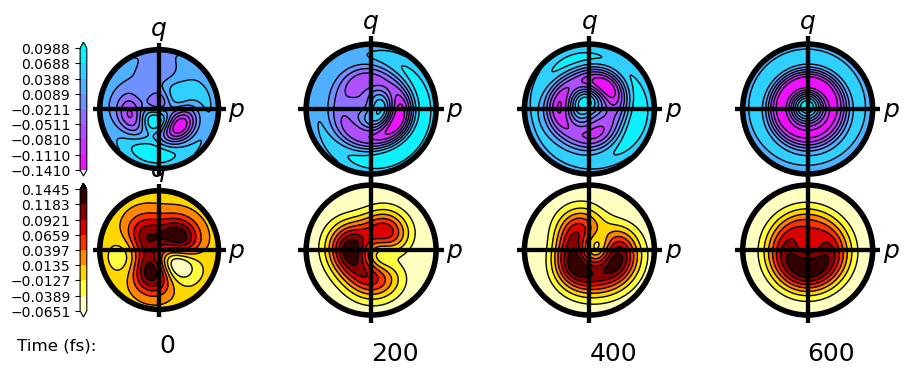

In [151]:
%matplotlib inline 
times = [0,200,400,600]
t_list = find_time_index(times,sim_time)

fig = plt.figure(figsize=(10,5))

for idx, m in enumerate(t_list):
    dm_dummy_GS = np.matrix(density_matrix[:,:,m])
    dm_dummy_ES = np.matrix(density_matrix[:,:,m])
    dm_dummy_GS[2:4,2:4] = 0+0j
    dm_dummy_ES[0:2,0:2] = 0+0j
    dm_dummy_GS =Qobj(dm_dummy_GS)
    dm_dummy_ES =Qobj(dm_dummy_ES)
    
    W_GS = wigner(dm_dummy_GS, xvec, xvec, method='laguerre')
    W_ES = wigner(dm_dummy_ES, xvec, xvec, method='laguerre')
    
    name = str(times[idx])
    radius = 2.5
    [size_W_GS,size_W_GS] = np.shape(W_GS)
    xy_interval = radius*2/size_W_GS

    for i in range(-int(vec_interval/2),int(vec_interval/2),1):
        for j in range(-int(vec_interval/2),int(vec_interval/2),1):

            if np.sqrt((i*xy_interval)**2+(j*xy_interval)**2)>radius-0.36:
                W_ES[i+int(vec_interval/2),j+int(vec_interval/2)] = np.NaN
                W_GS[i+int(vec_interval/2),j+int(vec_interval/2)] = np.NaN
                
###################################
    ax = fig.add_subplot(1,len(t_list), idx+1 ,aspect =1)
    plt.tight_layout()
    poslim = np.nanmax(W_GS) 
    neglim = np.nanmin(W_GS) 
    interval = (poslim-neglim)/8
    levels = np.arange(neglim,(poslim+interval),interval) 
    cmap_1 = cm.get_cmap('hot_r')
    cmap_1.set_under('white')
    cf = ax.contourf(X, Y, W_GS, levels, cmap = cmap_1 ,extend="both")
    if idx == 0:    
        cb=plt.colorbar(cf,orientation='vertical',fraction=0.046, pad=0.04, location='left')
        
    cf = ax.contour(X, Y, W_GS, levels, colors='black', extend="both",linestyles='solid',negative_linestyles='solid',linewidths = 1)

    xy_center = [0,0]   # center of the plot
    circle = mpl.patches.Circle(xy = xy_center, radius = radius, edgecolor = "black", facecolor = "none",linewidth = 4)
    
    ax.add_patch(circle)
    i = radius+0.3
    xy = [[i,0], [0,0],[-i,0]]
    polygon=mpl.patches.Polygon(xy = xy, edgecolor = "black", facecolor = "none",linewidth = 3)
    ax.add_patch(polygon)
    xy = [[0,i], [0,0],[0,-i]]
    polygon=mpl.patches.Polygon(xy = xy, edgecolor = "black", facecolor = "none",linewidth = 3)
    ax.add_patch(polygon)
    
    plt.axis('off')
    
    t_print = times[idx]
   
    #ax.text(0,-5, t_print , fontsize=20,weight='bold',horizontalalignment='center') 
    ax.text(0,radius+0.6, 'q' , fontsize=18,horizontalalignment='center',style='italic')
    ax.text(radius+0.4,0, 'p' , fontsize=18,verticalalignment='center',style='italic')
    ax.text(0,-4, name , fontsize=18,verticalalignment='center')
    if idx == 0:
        ax.text(-6,-4, str('Time (fs):') , fontsize=12,verticalalignment='center',)
    
    ########
    ax = fig.add_subplot(2,len(t_list), idx+1 ,aspect =1)
    plt.tight_layout()
    poslim = np.nanmax(W_ES) 
    neglim = np.nanmin(W_ES) 
    interval = (poslim-neglim)/8
    levels = np.arange(neglim,poslim+interval,interval) 
 
    cmap = cm.get_cmap('cool_r')
    cmap.set_under('white')
    cf = ax.contourf(X, Y, W_ES, levels, cmap = cmap ,extend="both")
    if idx == 0:    
        cb=plt.colorbar(cf,orientation='vertical',fraction=0.046, pad=0.04, location='left')
    cf = ax.contour(X, Y, W_ES, levels, colors='black', extend="both",linestyles='solid',negative_linestyles='solid',linewidths = 1)

    xy_center = [0,0]   # center of the plot
    circle = mpl.patches.Circle(xy = xy_center, radius = radius, edgecolor = "black", facecolor = "none",linewidth = 4)
    
    ax.add_patch(circle)
    i = radius+0.3
    xy = [[i,0], [0,0],[-i,0]]
    polygon=mpl.patches.Polygon(xy = xy, edgecolor = "black", facecolor = "none",linewidth = 3)
    ax.add_patch(polygon)
    xy = [[0,i], [0,0],[0,-i]]
    polygon=mpl.patches.Polygon(xy = xy, edgecolor = "black", facecolor = "none",linewidth = 3)
    ax.add_patch(polygon)
    
    plt.axis('off')
    
    t_print = times[idx]
   
    #ax.text(0,-5, t_print , fontsize=20,weight='bold',horizontalalignment='center') 
    ax.text(0,radius+0.6, 'q' , fontsize=18,horizontalalignment='center',style='italic')
    ax.text(radius+0.4,0, 'p' , fontsize=18,verticalalignment='center',style='italic')
        
    plt.subplots_adjust(wspace=0.5, hspace=0.5)
plt.draw


Bloch diagrams

GS Only no coherences

In [152]:
[a,b,c]=np.shape(density_matrix)
dm_1_blank = np.zeros((a,b,c), dtype=complex)
DM_1 = dm_1_blank
DM_1[0:2,0:2,:]= density_matrix[0:2,0:2,:]
density_matrix = DM_1



Scaling DM

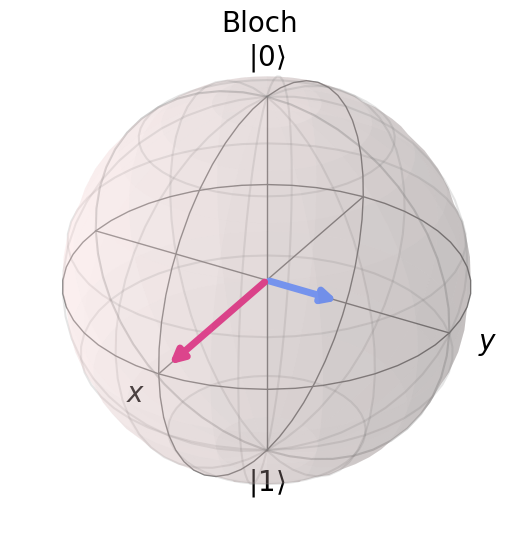

In [170]:
scaled_dm = np.abs((density_matrix)/np.max(density_matrix))
plot_bloch_vector(scaled_dm[:,:,5], title="Bloch")